
# Predicting Cancer Types from Mutational Profiles and Signature Activities

**Course Group Project — Final Notebook**  
**Authors:** _<add your names>_  
**Date:** _<run date>_

## What this notebook does
We use mutational **catalogues** (96 trinucleotide profiles) and predicted mutational **signature activities** to predict **cancer types**. We:

- Split data into **train/test within each cancer type** (stratified).
- Evaluate **feature sets**: profiles-only, activities-only, and **combined**.
- Train multiple **classification models** and explain, in brief, how each works.
- Report performance: accuracy, precision/recall/F1, **confusion matrices**, and per–cancer type results.
- Compare performance **across models** and **across cancer types**; discuss which types are easier vs. harder to predict.

> **Data sources** (as provided):
> - WGS catalogues & activities: `./project_data/catalogs/WGS/*.csv`, `./project_data/activities/WGS/*.csv`
> - WES catalogues & activities: `./project_data/catalogs/WES/*.csv`, `./project_data/activities/WES/*.csv`

### References
- Passenger-mutation–based cancer type classification with WGS achieves ~91% accuracy on held-out PCAWG and generalizes to external primaries/metastases; driver features add little compared with SNV type/distribution \[Jiao *et al.*, 2020\].
- Mutational signatures repertoire across cancers and extraction via NMF (SigProfiler/SignatureAnalyzer) \[Alexandrov *et al.*, 2020\].



In [1]:

# Core
import os, re, json, math, warnings
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (classification_report, confusion_matrix, f1_score, accuracy_score,
                             precision_recall_fscore_support)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.inspection import permutation_importance

warnings.filterwarnings('ignore')
print('Versions: pandas', pd.__version__)


Versions: pandas 2.3.3


In [2]:

# =========================
# Configuration
# =========================
RANDOM_STATE = 42
TEST_SIZE = 0.2
N_JOBS = -1

# Whether to include WGS, WES, or both
INCLUDE_WGS = True
INCLUDE_WES = True

# Paths (relative to this notebook)
PATHS = {
    'WGS': {
        'catalogs': [
            './project_data/catalogs/WGS/WGS_PCAWG.96.csv',
            './project_data/catalogs/WGS/WGS_Other.96.csv'
        ],
        'activities': [
            './project_data/activities/WGS/WGS_PCAWG.activities.csv',
            './project_data/activities/WGS/WGS_Other.activities.csv'
        ]
    },
    'WES': {
        'catalogs': [
            './project_data/catalogs/WES/WES_TCGA.96.csv',
            './project_data/catalogs/WES/WES_Other.96.csv'
        ],
        'activities': [
            './project_data/activities/WES/WES_TCGA.activities.csv',
            './project_data/activities/WES/WES_Other.activities.csv'
        ]
    }
}

# Minimum samples per class to keep (helps with robust stratification)
MIN_SAMPLES_PER_CLASS = 15

# Quick vs thorough run (set to 'thorough' to increase CV folds / permutations)
RUN_MODE = 'quick'  # 'quick' or 'thorough'


In [3]:
# --- Helpers & loaders (PCAWG wide format) ---

import re, os
import numpy as np
import pandas as pd

def collapse_duplicates(df, how='sum'):
    """Collapse duplicate index rows for the same sample ID."""
    if not df.index.duplicated().any():
        return df
    num = df.select_dtypes(include=[np.number])
    non = df.drop(columns=num.columns, errors='ignore')
    agg = num.groupby(level=0).sum() if how == 'sum' else num.groupby(level=0).mean()
    if not non.empty:
        agg_non = non.groupby(level=0).first()
        return agg.join(agg_non, how='left')
    return agg

def row_normalize(df):
    """Row-normalize to sum=1."""
    s = df.sum(axis=1)
    s = s.replace(0, np.nan)
    return df.div(s, axis=0).fillna(0.0)

def make_sbs96_name(tri, mut):
    """
    Convert (Trinucleotide='ACA', Mutation type='C>A') -> 'A[C>A]A'
    Assumes mutated base is the middle position of trinucleotide (PCAWG standard).
    """
    tri = str(tri); mut = str(mut)
    if len(tri) == 3 and '>' in mut:
        return f"{tri[0]}[{mut}]{tri[2]}"
    return f"{tri}:{mut}"  # fallback

def load_catalogs_wide(paths):
    """
    PCAWG 96-channel catalogs:
      columns = ['Mutation type','Trinucleotide','<Type>::<Sample>', ...]
    Returns:
      X_profiles: (n_samples x 96) row-normalized
      y: Series of labels parsed from header left side (<Type>)
    """
    mats = []
    labels = {}
    for p in paths:
        df = pd.read_csv(p)
        if not {'Mutation type','Trinucleotide'}.issubset(df.columns):
            raise ValueError(f"{p} missing columns: 'Mutation type','Trinucleotide'.")
        meta = ['Mutation type','Trinucleotide']
        sample_cols = [c for c in df.columns if c not in meta]
        features = df.apply(lambda r: make_sbs96_name(r['Trinucleotide'], r['Mutation type']), axis=1)
        wide = df[sample_cols]
        wide.index = features                         # rows = 96 contexts
        M = wide.T                                    # samples x contexts
        M.index = [str(s) for s in M.index]           # use full '<Type>::<SampleID>'
        for s in M.index:
            labels[s] = s.split('::', 1)[0] if '::' in s else 'Unknown'
        mats.append(M)

    X_profiles = pd.concat(mats, axis=0)
    if X_profiles.index.duplicated().any():
        X_profiles = collapse_duplicates(X_profiles, how='sum')
    X_profiles = row_normalize(X_profiles)
    y = pd.Series({s: labels.get(s, 'Unknown') for s in X_profiles.index}, name='label')
    return X_profiles, y

def load_activities(paths):
    """
    Two formats supported:
      A) rows=signatures (column 'Signature'), columns='<Type>::<SampleID>'  -> transpose
      B) rows=samples, signature columns named 'SBS*'|'DBS*'|'ID*', plus some ID column
    Returns:
      X_acts: (n_samples x n_signatures) row-normalized
      y_act: labels parsed from headers (when available), else None
    """
    mats, labels = [], {}
    for p in paths:
        df = pd.read_csv(p)

        # Case A: signature column present; headers are samples
        sig_col = next((c for c in ['Signature','signature','SIG','sig'] if c in df.columns), None)
        if sig_col:
            sigs = df[sig_col].astype(str)
            sample_cols = [c for c in df.columns if c != sig_col]
            wide = df[sample_cols]
            wide.index = sigs
            M = wide.T
            M.index = [str(s) for s in M.index]
            for s in M.index:
                if '::' in s:
                    labels[s] = s.split('::',1)[0]
            mats.append(M)
            continue

        # Case B: samples already rows; signatures as columns
        sig_cols = [c for c in df.columns if re.match(r'^(SBS|DBS|ID)\d+', str(c))]
        if sig_cols:
            non_sig = [c for c in df.columns if c not in sig_cols]
            if non_sig:
                id_col = max(non_sig, key=lambda c: df[c].astype(str).nunique(dropna=True))
            else:
                df['__tmp_id__'] = [f"{os.path.basename(p)}::row{i}" for i in range(len(df))]
                id_col = '__tmp_id__'
            M = df.set_index(df[id_col].astype(str))[sig_cols].copy()
            mats.append(M)
            continue

        # else: ignore file silently if layout unknown

    if not mats:
        return pd.DataFrame(), None

    X_acts = pd.concat(mats, axis=0)
    if X_acts.index.duplicated().any():
        X_acts = collapse_duplicates(X_acts, how='sum')
    X_acts = row_normalize(X_acts)
    y_act = pd.Series({s: labels.get(s, 'Unknown') for s in X_acts.index}, name='label') if labels else None
    return X_acts, y_act

In [5]:
# Merge strategy: use only samples that are in BOTH catalogs and activities (recommended)
MERGE_STRATEGY = 'intersection'   # change to 'catalog_only' to ignore activities

def build_block(kind='WGS'):
    Xp, yp = load_catalogs_wide(PATHS[kind]['catalogs'])
    Xa, ya = load_activities(PATHS[kind]['activities'])

    if MERGE_STRATEGY == 'catalog_only' or Xa.empty:
        X_block, y_block = Xp, yp
    else:
        common = Xp.index.intersection(Xa.index)
        if len(common) > 0:
            X_block = pd.concat([Xp.loc[common], Xa.loc[common]], axis=1)
            y_block = yp.loc[common]          # labels from catalogs
        else:
            # no overlap; safest is to use catalogs only (labels guaranteed)
            X_block, y_block = Xp, yp

    X_block['__source_kind__'] = kind
    return X_block, y_block

# Assemble blocks
X_list, y_list = [], []
if INCLUDE_WGS:
    X_wgs, y_wgs = build_block('WGS')
    X_list.append(X_wgs); y_list.append(y_wgs)
if INCLUDE_WES:
    X_wes, y_wes = build_block('WES')
    X_list.append(X_wes); y_list.append(y_wes)

# Combine
X = pd.concat(X_list, axis=0)
y = pd.concat(y_list, axis=0)

# Drop the helper column
if '__source_kind__' in X.columns:
    X = X.drop(columns=['__source_kind__'])

# Collapse duplicates
if not X.index.is_unique:
    print(f"[INFO] Collapsing {X.index.duplicated().sum()} duplicate sample rows (mean).")
    X = X.groupby(level=0).mean()
if y.index.duplicated().any():
    print(f"[INFO] Collapsing {y.index.duplicated().sum()} duplicate labels (mode).")
    def pick_mode(s):
        m = s.mode()
        return m.iat[0] if not m.empty else s.iloc[0]
    y = y.groupby(level=0).apply(pick_mode)

# Align and drop unlabeled
common_idx = X.index.intersection(y.index)
X = X.loc[common_idx].copy()
y = y.loc[common_idx].copy()
missing = y.isna()
if missing.any():
    print(f"[INFO] Dropping {missing.sum()} unlabeled samples.")
    X = X.loc[~missing].copy()
    y = y.loc[~missing].copy()

print("Samples:", X.shape[0], "| Features:", X.shape[1])
print("Unique index?", X.index.is_unique)
print("y nulls:", y.isna().sum())
print("Top labels:\n", y.value_counts().head(10))


Samples: 23829 | Features: 96
Unique index? True
y nulls: 0
Top labels:
 label
Breast-cancer       1637
Liver-HCC           1318
ColoRect-AdenoCa    1125
Skin-Melanoma       1070
Lung-AdenoCa         885
Lymph-BNHL           822
Prost-AdenoCa        805
Head-SCC             798
Kidney-RCC           775
Panc-AdenoCa         766
Name: count, dtype: int64


In [6]:
def harmonize_header_label(lbl):
    mapping = {
        'Bone-Benign': 'Bone',
        'Bone-Epith' : 'Bone',
        # add any other merges your instructor wants
    }
    return mapping.get(lbl, lbl)

y = y.map(harmonize_header_label)
print("Label counts (top):\n", y.value_counts().head(10))

Label counts (top):
 label
Breast-cancer       1637
Liver-HCC           1318
ColoRect-AdenoCa    1125
Skin-Melanoma       1070
Lung-AdenoCa         885
Lymph-BNHL           822
Prost-AdenoCa        805
Head-SCC             798
Kidney-RCC           775
Panc-AdenoCa         766
Name: count, dtype: int64


{'profiles_only': 96, 'combined': 96}
Train size: (18989, 96)  Test size: (4748, 96)

=== Feature set: profiles_only | Model: logreg_en ===

=== Feature set: profiles_only | Model: rf ===

=== Feature set: profiles_only | Model: hgb ===

=== Feature set: profiles_only | Model: linear_svm ===

=== Feature set: profiles_only | Model: mlp ===

=== Feature set: combined | Model: logreg_en ===

=== Feature set: combined | Model: rf ===

=== Feature set: combined | Model: hgb ===

=== Feature set: combined | Model: linear_svm ===

=== Feature set: combined | Model: mlp ===


,feature_set,model,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro
9,combined,mlp,0.375737,0.310641,0.375125,0.320268,0.311569
6,combined,rf,0.404381,0.277408,0.372233,0.381490,0.270030
5,combined,logreg_en,0.243050,0.200063,0.250291,0.198435,0.307174
7,combined,hgb,0.270851,0.181247,0.286044,0.192036,0.202131
8,combined,linear_svm,0.210615,0.146213,0.193929,0.177861,0.270678
4,profiles_only,mlp,0.376158,0.321431,0.373578,0.335372,0.317995
1,profiles_only,rf,0.402064,0.276298,0.370931,0.373091,0.269625
0,profiles_only,logreg_en,0.243050,0.200063,0.250291,0.198435,0.307174
2,profiles_only,hgb,0.265796,0.173719,0.281990,0.186397,0.199243
3,profiles_only,linear_svm,0.210615,0.146213,0.193929,0.177861,0.270678


Best models per feature set:


,feature_set,model,accuracy,f1_macro,f1_weighted,precision_macro,recall_macro
9,combined,mlp,0.375737,0.310641,0.375125,0.320268,0.311569
4,profiles_only,mlp,0.376158,0.321431,0.373578,0.335372,0.317995


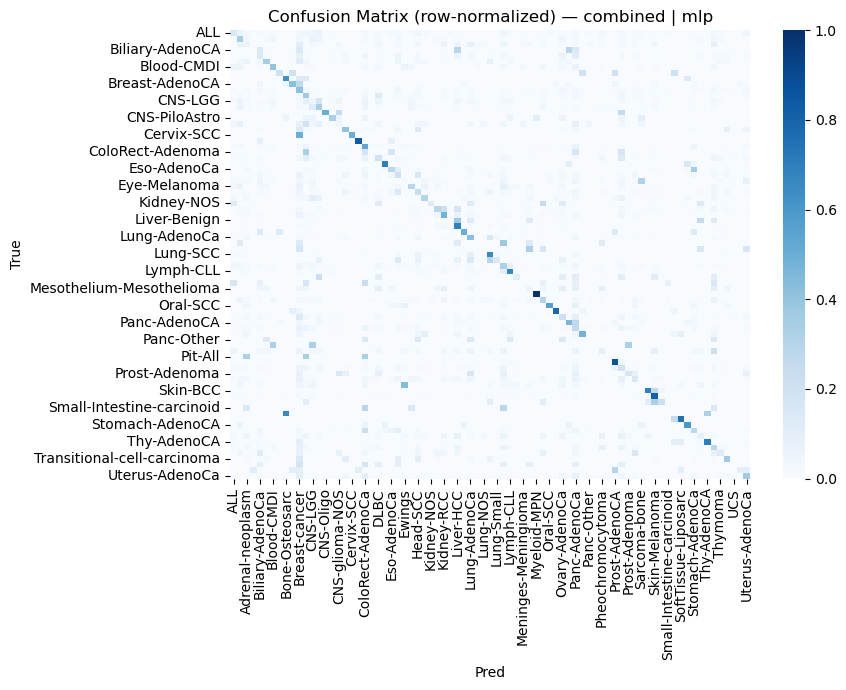

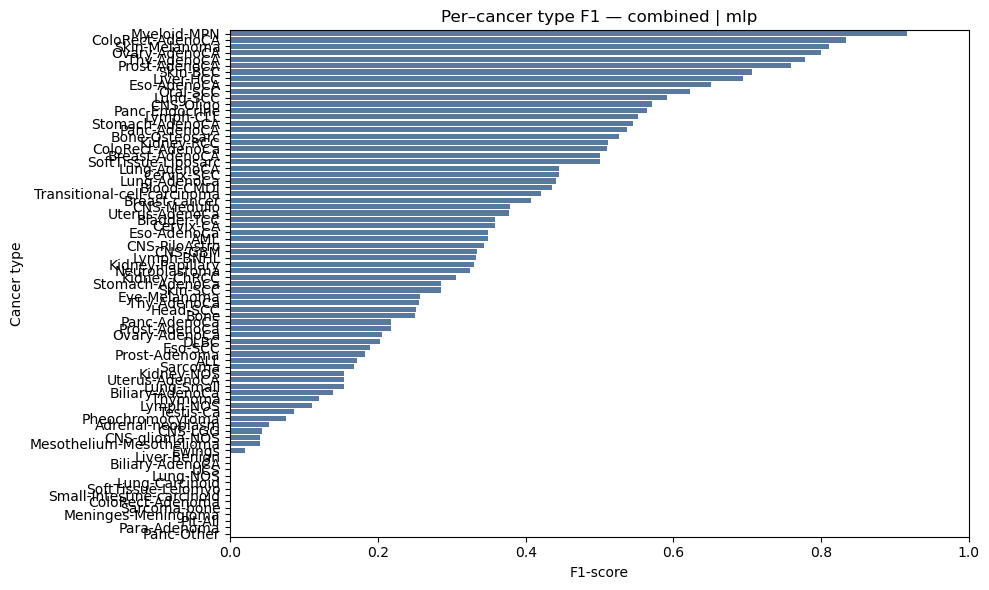

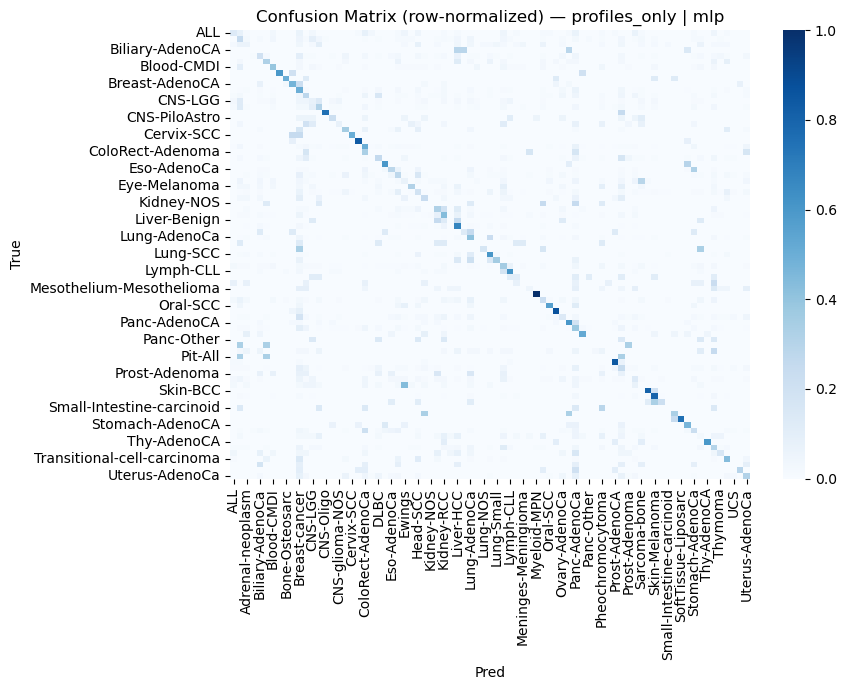

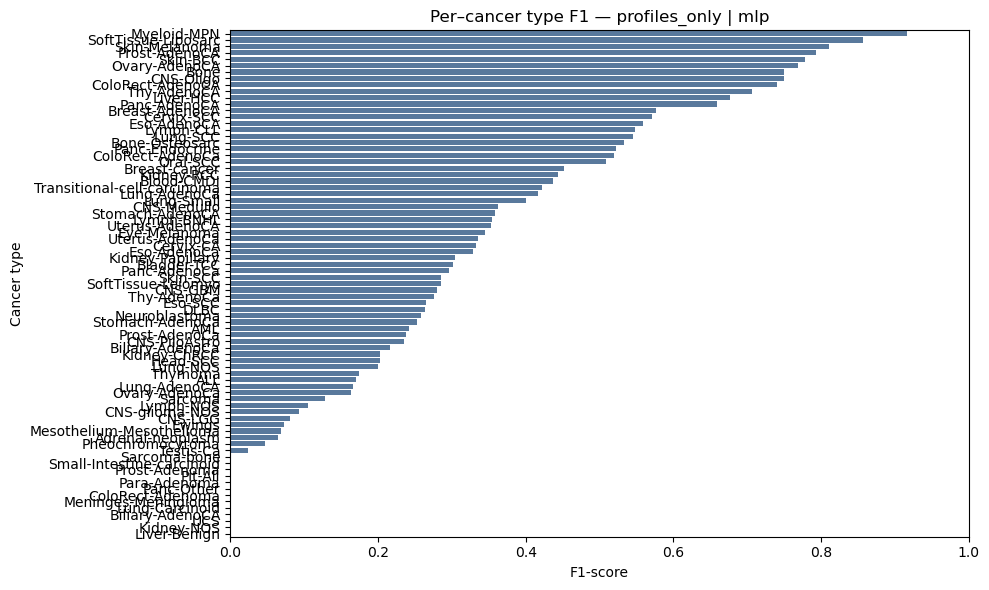

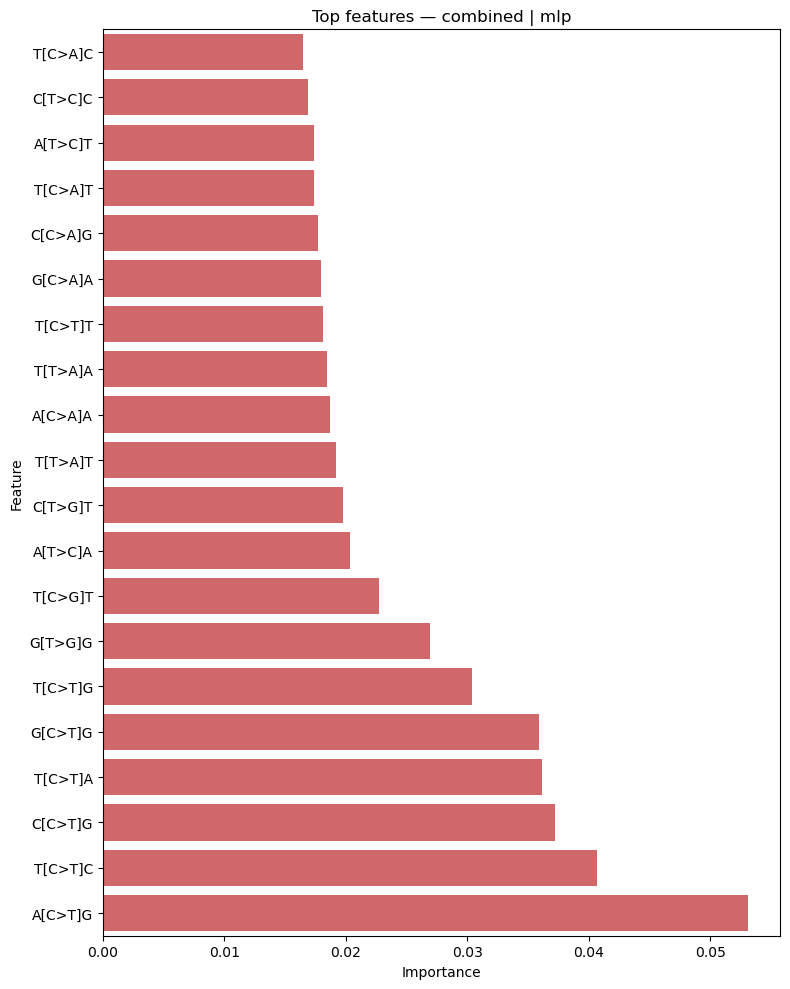

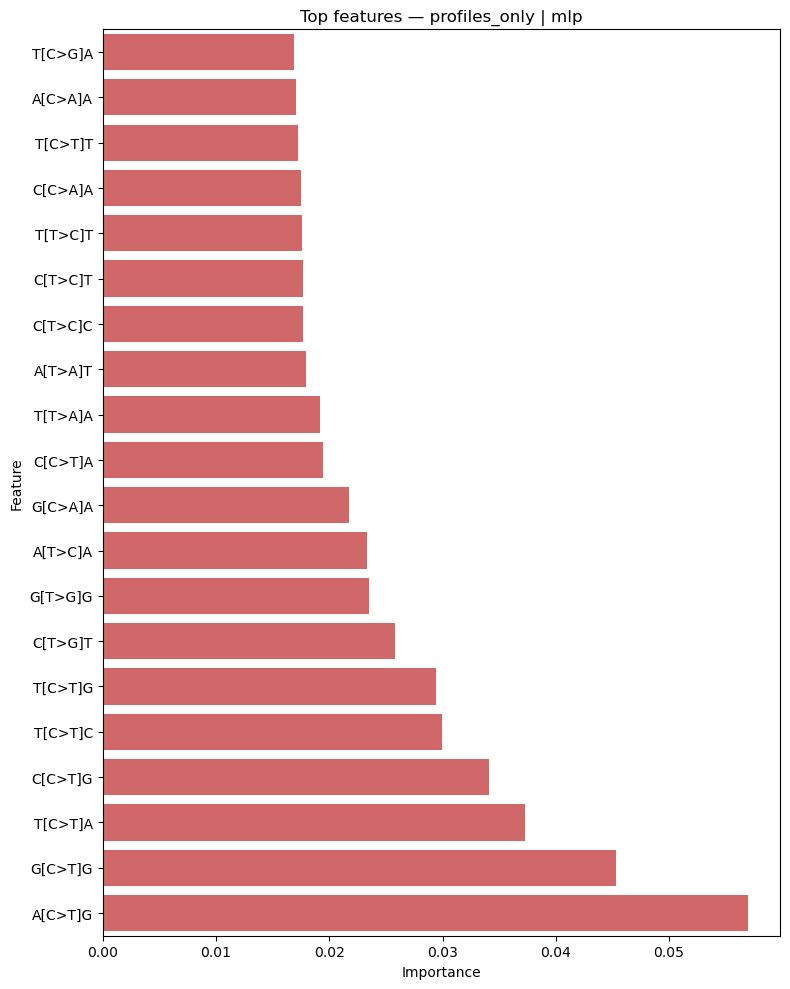

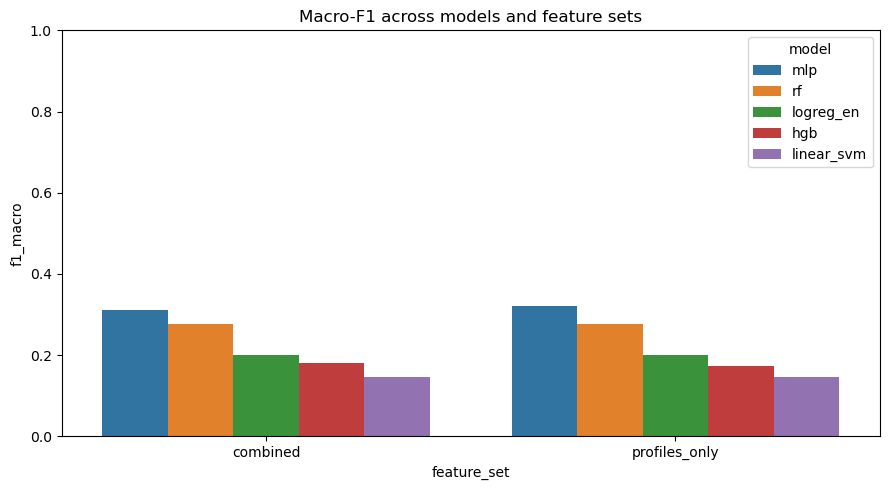

Saved: model_results_summary.csv


In [8]:
# Feature groups
profile_cols  = [c for c in X.columns if ('[' in str(c) and '>' in str(c) and ']' in str(c))]          # e.g. 'A[C>A]A'
activity_cols = [c for c in X.columns if re.match(r'^(SBS|DBS|ID)\d+', str(c))]                        # e.g. SBS1

FSETS = {}
if profile_cols:  FSETS['profiles_only']   = profile_cols
if activity_cols: FSETS['activities_only'] = activity_cols
if profile_cols or activity_cols:
    FSETS['combined'] = sorted(set(profile_cols + activity_cols))

print({k: len(v) for k, v in FSETS.items()})

# Filter low-sample classes and split
def filter_min_samples(X, y, min_n=15):
    vc = y.value_counts()
    keep = vc[vc >= min_n].index
    mask = y.isin(keep)
    return X.loc[mask].copy(), y.loc[mask].copy()

Xf, yf = filter_min_samples(X, y, MIN_SAMPLES_PER_CLASS)
X_train, X_test, y_train, y_test = train_test_split(
    Xf, yf, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=yf
)
print('Train size:', X_train.shape, ' Test size:', X_test.shape)

# Models
MODELS = {
    'logreg_en': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LogisticRegression(
            penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=3000,
            class_weight='balanced', random_state=RANDOM_STATE
            # removed: multi_class='multinomial', n_jobs=N_JOBS
        ))
    ]),
    'rf': RandomForestClassifier(n_estimators=400, max_depth=None, n_jobs=N_JOBS,
                                class_weight='balanced', random_state=RANDOM_STATE),
    'hgb': HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_depth=None),
    'linear_svm': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', LinearSVC(C=1.0, class_weight='balanced', max_iter=5000))
    ]),
    'mlp': Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', MLPClassifier(hidden_layer_sizes=(256,128), activation='relu', alpha=1e-4,
                              batch_size=64, learning_rate_init=5e-4, max_iter=200,
                              random_state=RANDOM_STATE))
    ])
}

# Train & evaluate
results, reports, conf_mats = [], {}, {}
for fs_name, cols in FSETS.items():
    Xtr, Xte = X_train[cols], X_test[cols]
    for model_name, model in MODELS.items():
        print(f"\n=== Feature set: {fs_name} | Model: {model_name} ===")
        clf = model.fit(Xtr, y_train)
        y_pred = clf.predict(Xte)

        acc = accuracy_score(y_test, y_pred)
        pr, rc, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', zero_division=0)
        _, _, f1w, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=0)

        results.append({
            'feature_set': fs_name, 'model': model_name,
            'accuracy': acc, 'f1_macro': f1, 'f1_weighted': f1w,
            'precision_macro': pr, 'recall_macro': rc
        })

        reports[(fs_name, model_name)] = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        labels_sorted = sorted(y_test.unique())
        conf_mats[(fs_name, model_name)] = pd.DataFrame(
            confusion_matrix(y_test, y_pred, labels=labels_sorted),
            index=pd.Index(labels_sorted, name='True'),
            columns=pd.Index(labels_sorted, name='Pred')
        )

results_df = pd.DataFrame(results).sort_values(['feature_set','f1_macro'], ascending=[True, False])
display(results_df)

# Plots
best_idx = results_df.groupby('feature_set')['f1_macro'].idxmax()
best_rows = results_df.loc[best_idx]
print('Best models per feature set:')
display(best_rows)

for _, row in best_rows.iterrows():
    fs_name, model_name = row['feature_set'], row['model']
    cm = conf_mats[(fs_name, model_name)]
    plt.figure(figsize=(9,7))
    sns.heatmap(cm.div(cm.sum(1).replace(0, np.nan), axis=0), cmap='Blues', annot=False)
    plt.title(f'Confusion Matrix (row-normalized) — {fs_name} | {model_name}')
    plt.tight_layout()
    plt.show()

    rep = pd.DataFrame(reports[(fs_name, model_name)]).T
    rep = rep.loc[~rep.index.isin(['accuracy','macro avg','weighted avg'])].sort_values('f1-score', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(y=rep.index, x=rep['f1-score'], color='#4e79a7')
    plt.xlabel('F1-score'); plt.ylabel('Cancer type')
    plt.title(f'Per–cancer type F1 — {fs_name} | {model_name}')
    plt.xlim(0,1); plt.tight_layout(); plt.show()

# Feature importance for best models
from sklearn.inspection import permutation_importance

importance_records = []
for _, row in best_rows.iterrows():
    fs_name, model_name = row['feature_set'], row['model']
    cols = FSETS[fs_name]
    Xtr, Xte = X_train[cols], X_test[cols]

    model = MODELS[model_name].fit(Xtr, y_train)
    if model_name == 'rf':
        imp = model.feature_importances_
        df_imp = pd.DataFrame({'feature': cols, 'importance': imp}).nlargest(30, 'importance')
    elif model_name == 'logreg_en':
        clf = model.named_steps['clf']
        imp = np.abs(clf.coef_).mean(axis=0)
        df_imp = pd.DataFrame({'feature': cols, 'importance': imp}).nlargest(30, 'importance')
    else:
        r = permutation_importance(model, Xte, y_test, n_repeats=(5 if RUN_MODE=='quick' else 15),
                                   random_state=RANDOM_STATE, n_jobs=N_JOBS)
        df_imp = pd.DataFrame({'feature': cols, 'importance': r.importances_mean}).nlargest(30, 'importance')

    df_imp['feature_set'] = fs_name; df_imp['model'] = model_name
    importance_records.append(df_imp)

imp_all = pd.concat(importance_records, axis=0)
for (fs, mdl), sub in imp_all.groupby(['feature_set','model']):
    plt.figure(figsize=(8,10))
    sns.barplot(x='importance', y='feature', data=sub.sort_values('importance').tail(20), color='#e15759')
    plt.title(f'Top features — {fs} | {mdl}')
    plt.xlabel('Importance'); plt.ylabel('Feature')
    plt.tight_layout(); plt.show()

# Summary
plt.figure(figsize=(9,5))
sns.barplot(data=results_df, x='feature_set', y='f1_macro', hue='model')
plt.title('Macro-F1 across models and feature sets')
plt.ylim(0,1); plt.tight_layout(); plt.show()

results_df.to_csv('model_results_summary.csv', index=False)
print('Saved: model_results_summary.csv')

In [22]:
# Combine blocks
X = pd.concat(X_list, axis=0)
y = pd.concat(y_list, axis=0)

# Drop helper column now
if '__source_kind__' in X.columns:
    X = X.drop(columns=['__source_kind__'])

# ---------- collapse duplicate sample rows ----------
if not X.index.is_unique:
    print(f"[INFO] Collapsing {X.index.duplicated().sum()} duplicate sample rows (mean).")
    X = X.groupby(level=0).mean()

if y.index.duplicated().any():
    print(f"[INFO] Collapsing {y.index.duplicated().sum()} duplicate labels (mode).")
    def pick_mode(s):
        m = s.mode()
        return m.iat[0] if not m.empty else s.iloc[0]
    y = y.groupby(level=0).apply(pick_mode)

# Align indices strictly
common_idx = X.index.intersection(y.index)
X = X.loc[common_idx].copy()
y = y.loc[common_idx].copy()

# ---------- drop unlabeled rows ----------
missing = y.isna()
if missing.any():
    print(f"[INFO] Dropping {missing.sum()} unlabeled samples.")
    X = X.loc[~missing].copy()
    y = y.loc[~missing].copy()

# Final sanity
print("Samples:", X.shape[0], "| Features:", X.shape[1])
print("Unique index?", X.index.is_unique)
print("y nulls:", y.isna().sum())
print("Top labels:\n", y.value_counts().head(10))

[INFO] Collapsing 26 duplicate sample rows (mean).
[INFO] Collapsing 26 duplicate labels (mode).
[INFO] Dropping 23241 unlabeled samples.
Samples: 0 | Features: 65
Unique index? True
y nulls: 0
Top labels:
 Series([], Name: count, dtype: int64)
